# Настройка ноутбука

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Расширить рабочее поле ноутбука на весь экран
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Описание

**Видео:**
- [Bootstrapping Main Ideas!!!](https://www.youtube.com/watch?v=Xz0x-8-cgaQ&ab_channel=StatQuestwithJoshStarmer)

**Статьи:**
- [Medium: Resampling (Bootstrapping & Permutation Testing)](https://medium.com/@mattheweparker/common-machine-learning-resampling-methods-like-bootstrapping-and-permutation-testing-attempt-to-ddc4fbbda391)


# Bootstrapping

**Bootstrap** — практический компьютерный метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом Монте-Карло на базе имеющейся выборки. Позволяет просто и быстро оценивать самые разные статистики для сложных моделей.

- Если выборка репрезентативна, то ее можно рассматривать как модель генеральной совокупности.
- Bootstrap не является спасением от маленьких выборок.

In [6]:
M = 3 
sigma = 2 
N = 10_000

genpop = pd.Series(np.random.normal(M, sigma, N))

In [7]:
n_vals = 100
one_sample = genpop.sample(n=n_vals)

## Проверка устойчивости метода

In [8]:
l = []
n_bootstrap = 300
n_iterations = 9

for i in range(n_iterations):
    l.append([one_sample.sample(n_vals, replace=True).mean() for b in range(n_bootstrap)])

iterations = pd.DataFrame(l)

In [9]:
inds = list(range(iterations.shape[0]))

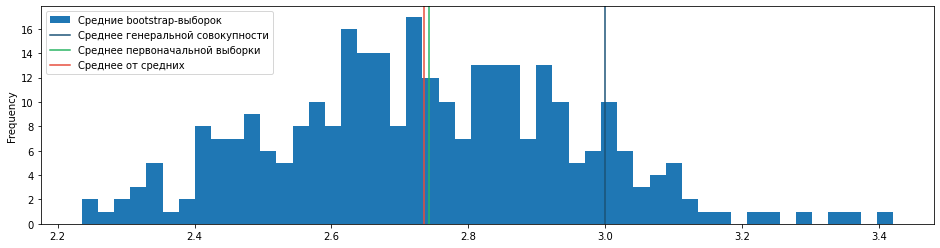

In [11]:
i = inds.pop(0) 

fig = plt.figure(figsize = (16, 4))
ax = fig.gca()
iterations.iloc[i].plot.hist(bins=50, ax = ax, label = 'Средние bootstrap-выборок')

plt.axvline(M,  color='#1A5276', label='Среднее генеральной совокупности')
plt.axvline(one_sample.mean(),  color='#28B463', label = 'Среднее первоначальной выборки')
plt.axvline(iterations.iloc[i].mean(),  color='#E74C3C', label = 'Среднее от средних')
plt.legend(loc='upper left');

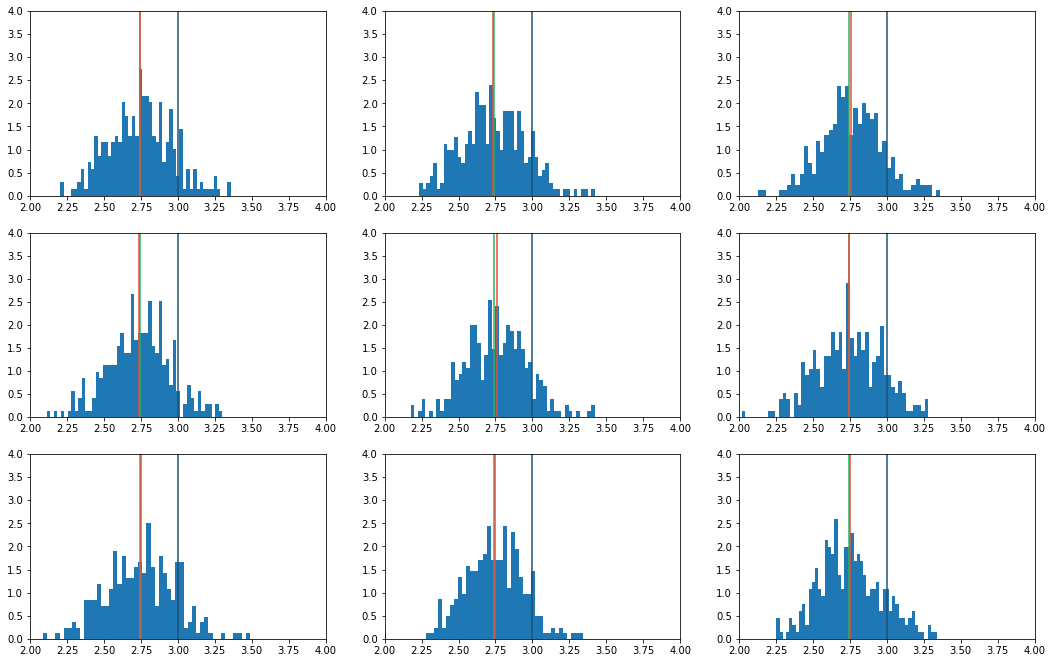

In [12]:
n = iterations.shape[0]

plt.figure(figsize=(n*2, n * 4))
for i in range(n):
    plt.subplot(n, 3, i+1)
    plt.axis([2, 4, 0, 4])
    plt.hist(iterations.iloc[i], bins=50, density=True)
    
    plt.axvline(M,  color='#1A5276')
    plt.axvline(one_sample.mean(),  color='#28B463')
    plt.axvline(iterations.iloc[i].mean(),  color='#E74C3C')
    
plt.show()

## Оценка среднего значения 

In [13]:
n_bootstrap = 300
bootstrap = pd.DataFrame([one_sample.sample(n_vals, replace=True).tolist() for b in range(n_bootstrap)])

In [14]:
def confidence_interval(n, mean_val, std_val, target_interval):
    alpha = 1 - target_interval
    z = abs(st.norm.ppf(alpha/2)) # 1.96
    se = std_val / np.sqrt(n)
    
    conf_val = np.round(z*se, 2)
    return conf_val, (np.round(mean_val - conf_val, 2), np.round(mean_val + conf_val, 2))

bootstrap_stats = pd.DataFrame({
    'n': bootstrap.apply(lambda row: len(row), axis=1),
    'mean_val': bootstrap.apply(lambda row: row.mean(), axis=1),
    'std_val': bootstrap.apply(lambda row: row.std(), axis=1),
})

bootstrap_stats[['conf_val', 'interval']] = bootstrap_stats.apply(lambda row: confidence_interval(row.n, row.mean_val, row.std_val, 0.95), axis=1).apply(pd.Series)
bootstrap_stats[['ci_left', 'ci_right']] = bootstrap_stats.interval.apply(pd.Series)

In [15]:
bootstrap_stats['error'] = bootstrap_stats.apply(lambda row: ((row['ci_left'] > M) | (row['ci_right'] < M)), axis=1)
bootstrap_stats.error.value_counts(normalize=True)

False    0.793333
True     0.206667
Name: error, dtype: float64

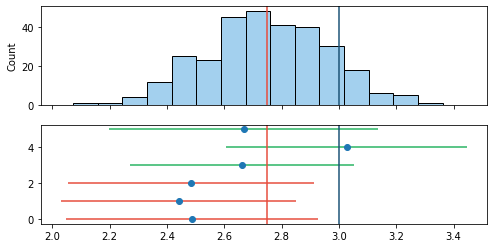

In [19]:
f, (ax_hist, ax_intervals) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .85)}, figsize = (8, 4))

sns.histplot(x=bootstrap_stats.mean_val, ax=ax_hist, color='#85C1E9')
ax_hist.axvline(M,  color='#1A5276')
ax_hist.axvline(bootstrap_stats.mean_val.mean(),  color='#E74C3C')


n_intervals = 10
intervals = pd.concat([
    bootstrap_stats[bootstrap_stats['ci_left'] > M].iloc[:n_intervals//3],
    bootstrap_stats[bootstrap_stats['ci_right'] < M].iloc[:n_intervals//3],
    bootstrap_stats[~((bootstrap_stats['ci_left'] > M) | (bootstrap_stats['ci_right'] < M))].iloc[:n_intervals//3],
])
intervals['color'] = intervals.apply(lambda row: '#E74C3C' if ((row['ci_left'] > M) | (row['ci_right'] < M)) else '#28B463', axis=1)

ax_intervals.errorbar(
    intervals.mean_val, 
    list(range(intervals.shape[0])), 
    xerr=[intervals.conf_val, intervals.conf_val], 
    fmt='o',
    ecolor=intervals.color.values
)

ax_intervals.axvline(M,  color='#1A5276')
ax_intervals.axvline(bootstrap_stats.mean_val.mean(),  color='#E74C3C');

При повторении эксперимента, точность bootstrap-выборки варьируется от 60 до 95%. В этом плане подход с несколькими выборками дает более точные, устойчивые результаты. Почему так?

#### [Pandas doc: pandas.plotting.bootstrap_plot](https://pandas.pydata.org/docs/reference/api/pandas.plotting.bootstrap_plot.html)

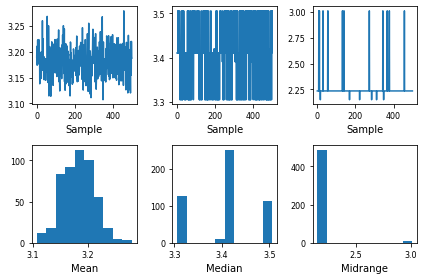

In [114]:
pd.plotting.bootstrap_plot(
    one_sample, 
    size=98, # Почему-то работает странно, если добавить сюда n_vals
    samples=500
);